# Classification Input/Output Visualization

This notebook provides comprehensive visualizations for:
- **Beat Classification**: Input sequences (RR intervals) and model outputs
- **Rhythm Classification**: Input sequences (RR intervals) and model outputs

## Contents
1. Setup and Data Loading
2. Beat Classification Visualizations
   - Input: Sequence samples, label distribution, feature statistics
   - Output: Predictions, probabilities, confusion matrix, ROC/PR curves
3. Rhythm Classification Visualizations
   - Input: Sequence samples, label distribution, feature statistics
   - Output: Predictions, probabilities, confusion matrix, ROC/PR curves

In [22]:
# Import libraries
import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Import our modules
from preprocess import (
    load_all_cases, create_sequence_dataset,
    BEAT_LABELS, RHYTHM_LABELS
)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)
from sklearn.preprocessing import label_binarize

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (14, 8)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [23]:
# Load all cases
print("📂 Loading data...")
annotations_dict, metadata_df = load_all_cases()

print(f"\n✅ Dataset loaded:")
print(f"   Total patients: {len(annotations_dict)}")
print(f"   Total beats: {metadata_df['total_beats'].sum():,}")
print(f"   Total duration: {metadata_df['analyzed_duration_sec'].sum()/3600:.1f} hours")


📂 Loading data...
Filtered 21 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 49 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 10 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 46 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 50 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 9 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 26 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 5 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 2 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 7 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 6 samples from 'rhythm_label' (excluded classes: ['Unclassifiable',

## Part 1: Beat Classification Visualizations


In [24]:
# Create beat sequence dataset
print("📊 Creating beat classification sequences...")
beat_sequences, beat_labels, beat_patient_ids = create_sequence_dataset(
    annotations_dict,
    metadata_df,
    task='beat',
    window_size=60,
    stride=30
)

print(f"\n✅ Beat sequences created:")
print(f"   Sequences: {beat_sequences.shape}")
print(f"   Labels: {len(beat_labels)}")
print(f"   Unique labels: {set(beat_labels)}")


📊 Creating beat classification sequences...
Creating sequence windows (size=60, stride=30)...
✅ Created 21595 windows from 482 patients

✅ Beat sequences created:
   Sequences: (21595, 60)
   Labels: 21595
   Unique labels: {np.str_('V'), np.str_('U'), np.str_('S'), np.str_('N')}


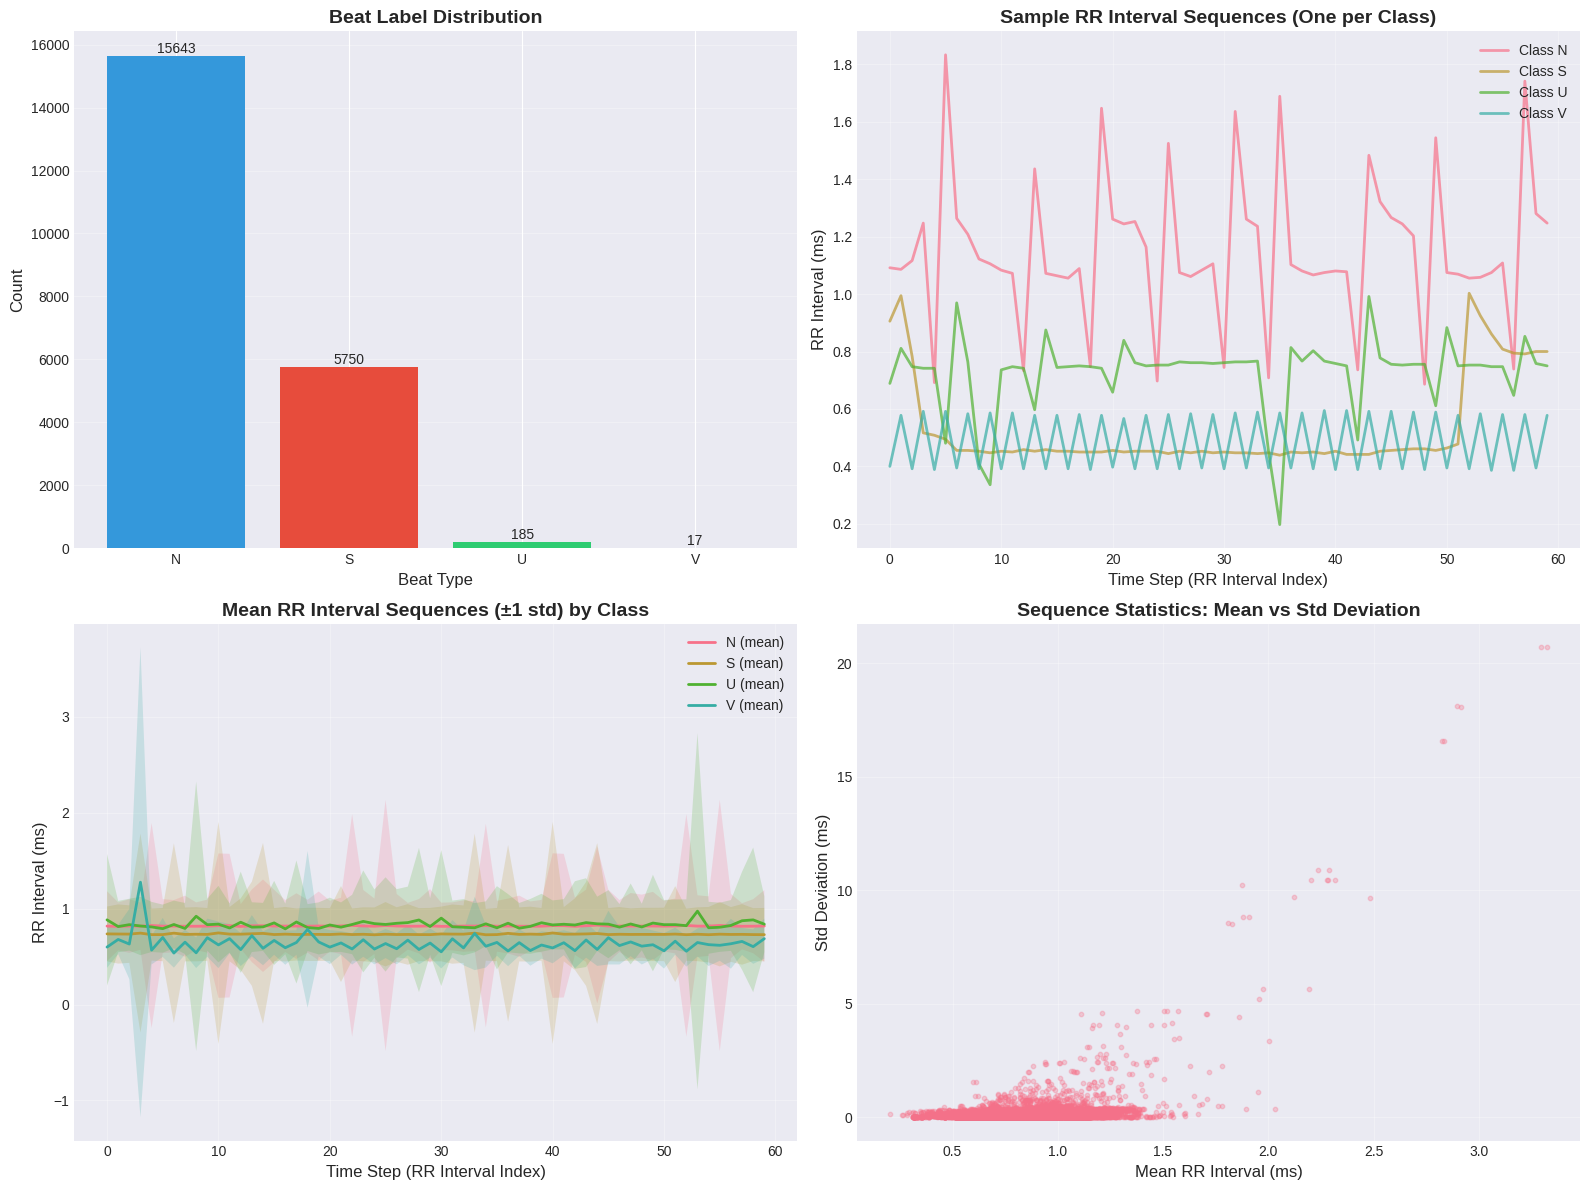


📊 Beat Classification Input Summary:
   Total sequences: 21595
   Sequence length: 60
   N: 15643 (72.44%)
   S: 5750 (26.63%)
   U: 185 (0.86%)
   V: 17 (0.08%)


In [25]:
# Visualize beat classification inputs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Label distribution
label_counts = pd.Series(beat_labels).value_counts()
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(label_counts)]
axes[0, 0].bar(label_counts.index, label_counts.values, color=colors)
axes[0, 0].set_title('Beat Label Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Beat Type', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(label_counts.values):
    axes[0, 0].text(i, v, str(v), ha='center', va='bottom', fontsize=10)

# 2. Sample sequences by class
unique_labels = np.unique(beat_labels)
sample_indices = []
for label in unique_labels:
    indices = np.where(np.array(beat_labels) == label)[0]
    if len(indices) > 0:
        sample_indices.append((indices[0], label))

for idx, label in sample_indices:
    sequence = beat_sequences[idx]
    axes[0, 1].plot(sequence, label=f'Class {label}', alpha=0.7, linewidth=2)
axes[0, 1].set_title('Sample RR Interval Sequences (One per Class)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Time Step (RR Interval Index)', fontsize=12)
axes[0, 1].set_ylabel('RR Interval (ms)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Sequence statistics by class
stats_by_class = {}
for label in unique_labels:
    class_indices = np.where(np.array(beat_labels) == label)[0]
    if len(class_indices) > 0:
        class_sequences = beat_sequences[class_indices]
        stats_by_class[label] = {
            'mean': np.mean(class_sequences, axis=0),
            'std': np.std(class_sequences, axis=0)
        }

for label in unique_labels:
    if label in stats_by_class:
        mean_seq = stats_by_class[label]['mean']
        std_seq = stats_by_class[label]['std']
        axes[1, 0].plot(mean_seq, label=f'{label} (mean)', linewidth=2)
        axes[1, 0].fill_between(range(len(mean_seq)), 
                                mean_seq - std_seq, 
                                mean_seq + std_seq, 
                                alpha=0.2)
axes[1, 0].set_title('Mean RR Interval Sequences (±1 std) by Class', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time Step (RR Interval Index)', fontsize=12)
axes[1, 0].set_ylabel('RR Interval (ms)', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of sequence statistics
sequence_means = np.mean(beat_sequences, axis=1)
sequence_stds = np.std(beat_sequences, axis=1)

axes[1, 1].scatter(sequence_means, sequence_stds, alpha=0.3, s=10)
axes[1, 1].set_title('Sequence Statistics: Mean vs Std Deviation', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Mean RR Interval (ms)', fontsize=12)
axes[1, 1].set_ylabel('Std Deviation (ms)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Beat Classification Input Summary:")
print(f"   Total sequences: {len(beat_labels)}")
print(f"   Sequence length: {beat_sequences.shape[1]}")
for label in unique_labels:
    count = np.sum(np.array(beat_labels) == label)
    pct = count / len(beat_labels) * 100
    print(f"   {label}: {count} ({pct:.2f}%)")


### Beat Classification Output Visualization

**Instructions**: 
1. Run `beat_dl.ipynb` notebook first to train the model and generate predictions
2. Copy the evaluation code from `beat_dl.ipynb` (Cell 17 onwards) into the cells below
3. Or load saved predictions from file


In [26]:
# BEAT CLASSIFICATION OUTPUT VISUALIZATION
# Load predictions from saved file (generated by beat_dl.ipynb)

import pickle
import os

# Find prediction file (try multiple locations)
current_dir = os.getcwd()
possible_paths = [
    os.path.join(current_dir, '..', 'experiments', 'results', 'predictions', 'beat_classification_predictions.pkl'),
    os.path.join(current_dir, 'experiments', 'results', 'predictions', 'beat_classification_predictions.pkl'),
    '../experiments/results/predictions/beat_classification_predictions.pkl',
    'experiments/results/predictions/beat_classification_predictions.pkl',
    # Also check old location for backwards compatibility
    os.path.join(current_dir, '..', 'results', 'predictions', 'beat_classification_predictions.pkl'),
]

pred_file = None
for path in possible_paths:
    abs_path = os.path.abspath(path)
    if os.path.exists(abs_path):
        pred_file = abs_path
        break

if pred_file and os.path.exists(pred_file):
    print(f"📂 Loading predictions from {pred_file}...")
    with open(pred_file, 'rb') as f:
        beat_predictions = pickle.load(f)
    
    test_pred_str = beat_predictions['test_pred_str']
    test_true_str = beat_predictions['test_true_str']
    test_proba = beat_predictions['test_proba']
    label_encoder = beat_predictions['label_encoder']
    
    print(f"✅ Predictions loaded successfully!")
    print(f"   Task: {beat_predictions['task']}")
    print(f"   Samples: {len(test_pred_str)}")
    print(f"   Classes: {beat_predictions['class_names']}")
    print(f"   Accuracy: {beat_predictions['accuracy']:.4f}")
    print(f"   AUROC: {beat_predictions['auroc']:.4f}")
    print(f"   AUPRC: {beat_predictions['auprc']:.4f}")
    print(f"\n   Ready for visualization! Run the cell below.")
else:
    print(f"⚠️  Prediction file not found: {pred_file}")
    print(f"    Please run beat_dl.ipynb first to generate predictions.")
    print(f"    The predictions will be saved automatically after evaluation.")


📂 Loading predictions from /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/beat_classification_predictions.pkl...
✅ Predictions loaded successfully!
   Task: beat
   Samples: 4419
   Classes: [np.str_('N'), np.str_('S'), np.str_('U'), np.str_('V')]
   Accuracy: 0.8821
   AUROC: 0.8665
   AUPRC: 0.5082

   Ready for visualization! Run the cell below.


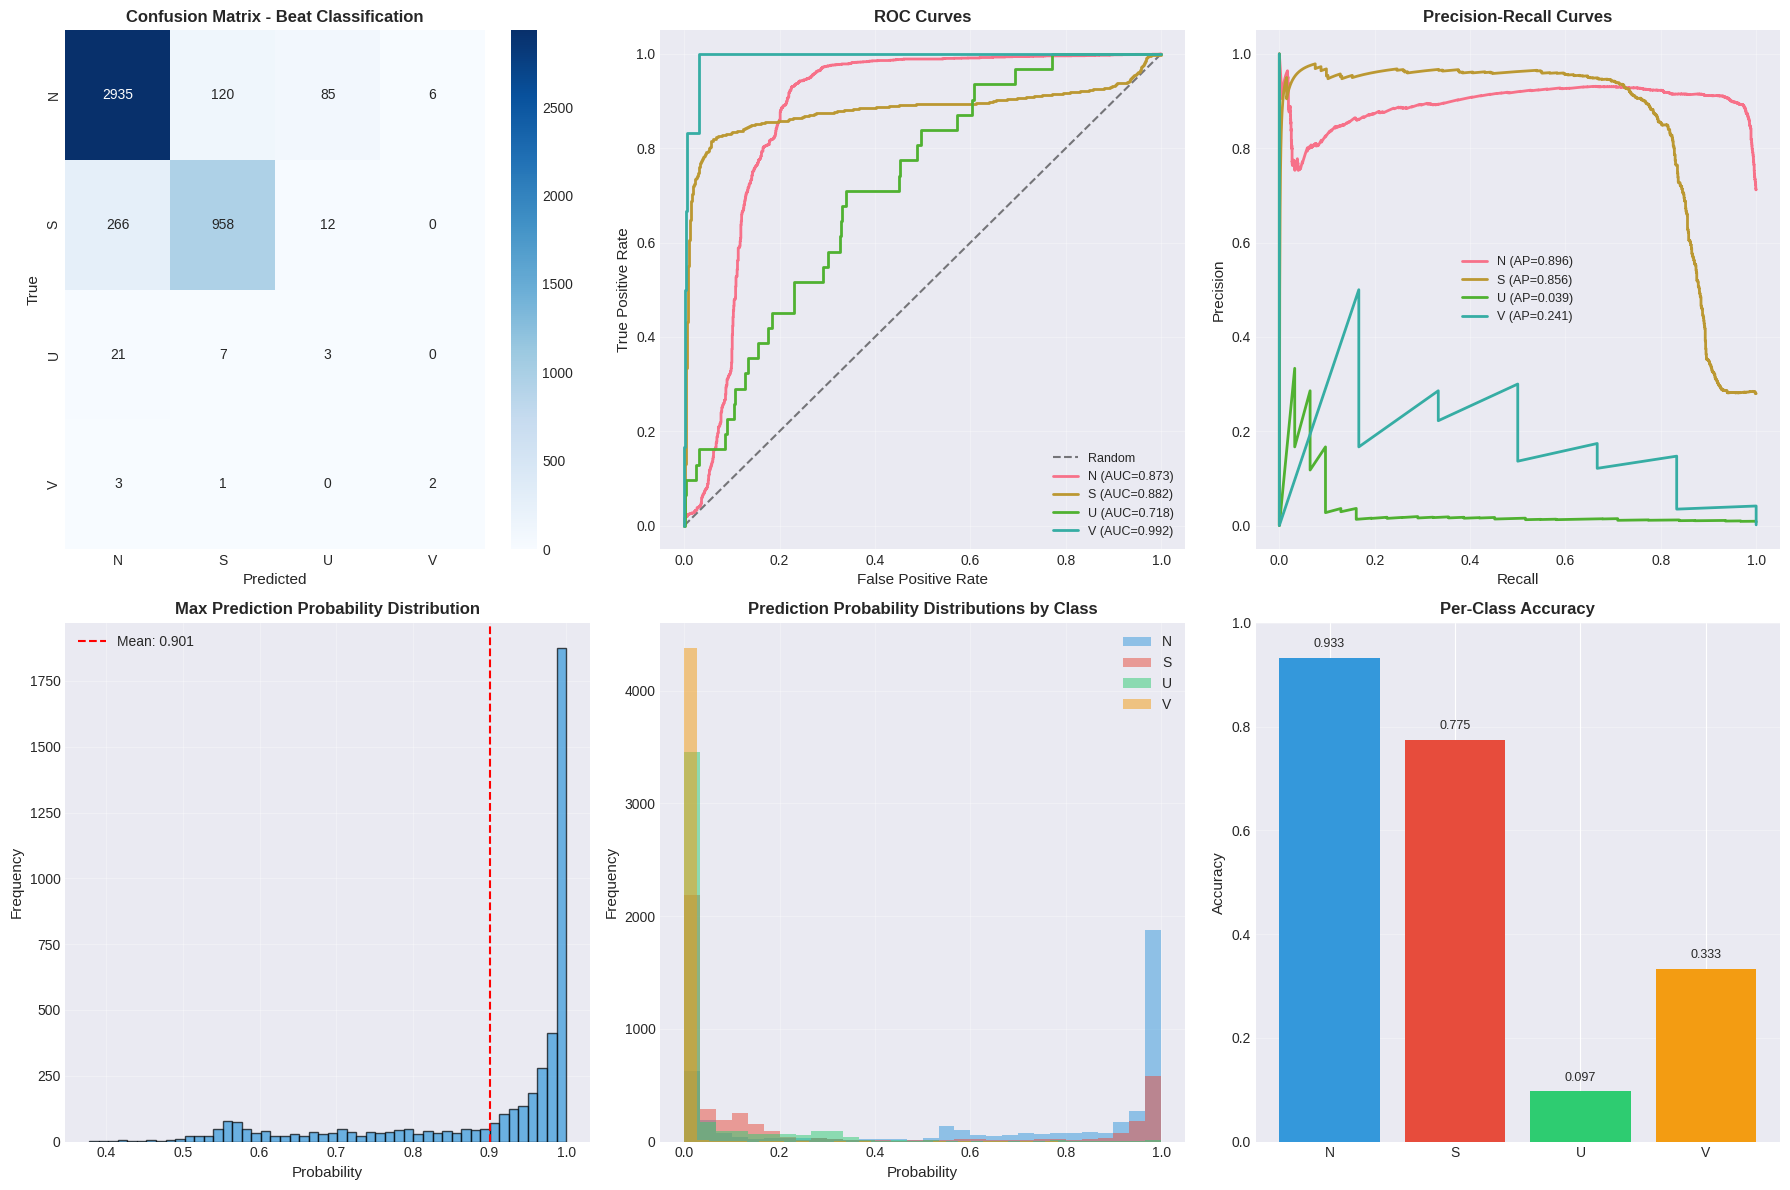


✅ Beat classification output visualizations complete!


In [27]:
# Visualize beat classification outputs
if 'test_pred_str' in locals() and os.path.exists(pred_file):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Confusion Matrix
    cm = confusion_matrix(test_true_str, test_pred_str, labels=label_encoder.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axes[0, 0].set_title('Confusion Matrix - Beat Classification', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted', fontsize=11)
    axes[0, 0].set_ylabel('True', fontsize=11)
    
    # ROC Curves
    y_true_binary = label_binarize(test_true_str, classes=label_encoder.classes_)
    axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], test_proba[:, i])
        auc_score = roc_auc_score(y_true_binary[:, i], test_proba[:, i])
        axes[0, 1].plot(fpr, tpr, label=f'{class_name} (AUC={auc_score:.3f})', linewidth=2)
    axes[0, 1].set_title('ROC Curves', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].set_xlabel('False Positive Rate', fontsize=11)
    axes[0, 1].set_ylabel('True Positive Rate', fontsize=11)
    
    # Precision-Recall Curves
    for i, class_name in enumerate(label_encoder.classes_):
        precision, recall, _ = precision_recall_curve(y_true_binary[:, i], test_proba[:, i])
        ap = average_precision_score(y_true_binary[:, i], test_proba[:, i])
        axes[0, 2].plot(recall, precision, label=f'{class_name} (AP={ap:.3f})', linewidth=2)
    axes[0, 2].set_title('Precision-Recall Curves', fontsize=12, fontweight='bold')
    axes[0, 2].legend(fontsize=9)
    axes[0, 2].grid(alpha=0.3)
    axes[0, 2].set_xlabel('Recall', fontsize=11)
    axes[0, 2].set_ylabel('Precision', fontsize=11)
    
    # Prediction confidence distribution
    max_probs = np.max(test_proba, axis=1)
    axes[1, 0].hist(max_probs, bins=50, alpha=0.7, edgecolor='black', color='#3498db')
    axes[1, 0].set_title('Max Prediction Probability Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Probability', fontsize=11)
    axes[1, 0].set_ylabel('Frequency', fontsize=11)
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].axvline(np.mean(max_probs), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(max_probs):.3f}')
    axes[1, 0].legend()
    
    # Per-class probability distributions
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(label_encoder.classes_)]
    for i, class_name in enumerate(label_encoder.classes_):
        axes[1, 1].hist(test_proba[:, i], bins=30, alpha=0.5, label=class_name, color=colors[i])
    axes[1, 1].set_title('Prediction Probability Distributions by Class', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Probability', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    # Accuracy by class
    from sklearn.metrics import accuracy_score
    per_class_acc = []
    for class_name in label_encoder.classes_:
        class_mask = np.array(test_true_str) == class_name
        if np.sum(class_mask) > 0:
            class_acc = accuracy_score(
                np.array(test_true_str)[class_mask],
                np.array(test_pred_str)[class_mask]
            )
            per_class_acc.append(class_acc)
        else:
            per_class_acc.append(0)
    
    axes[1, 2].bar(label_encoder.classes_, per_class_acc, color=colors)
    axes[1, 2].set_title('Per-Class Accuracy', fontsize=12, fontweight='bold')
    axes[1, 2].set_ylabel('Accuracy', fontsize=11)
    axes[1, 2].set_ylim([0, 1])
    axes[1, 2].grid(axis='y', alpha=0.3)
    for i, v in enumerate(per_class_acc):
        axes[1, 2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Beat classification output visualizations complete!")
else:
    print("⚠️  Predictions not loaded. Please run the previous cell first.")


### Beat Classification: Sample Input-Output Visualization

Visualize individual samples showing the input sequence (RR intervals) and the model's prediction.


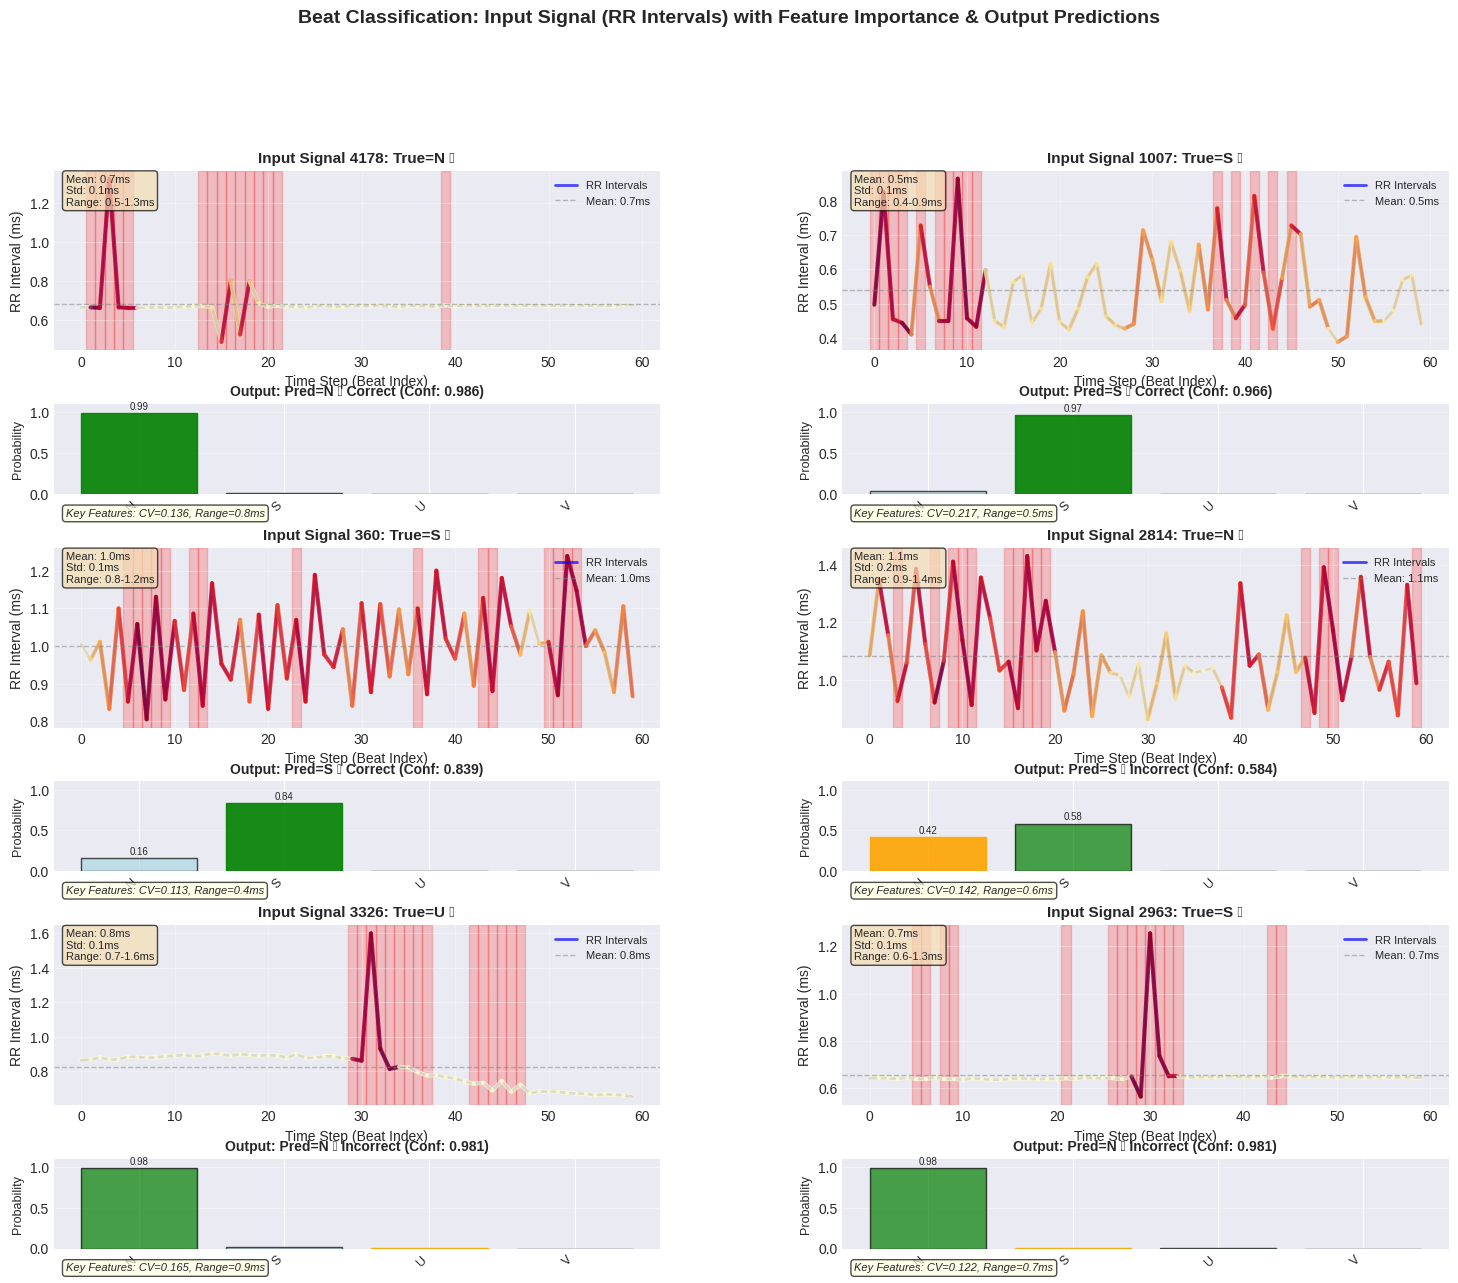


📊 Feature Importance Explanation:
   • Color-coding in signal:
     - Red/Yellow: High local variance (irregular rhythm patterns)
     - Blue: Normal variability (regular rhythm)
     - Red shaded regions: Top 25% most variable segments
   • Outlier detection:
     - Points >1.5 std from mean are highlighted
     - These represent abnormal RR intervals (arrhythmia indicators)
   • How features affect output:
     - High variance regions → Important for distinguishing classes
     - Outliers → Strong indicators of specific arrhythmia types
     - CV (Coefficient of Variation) → Overall rhythm regularity metric

📊 Displayed 6 sample predictions:
   Correct predictions: 3
   Incorrect predictions: 3

⚠️  Note: To visualize the actual input sequences (RR intervals), 
    you would need to load/recreate the test sequences.
    The sequences shown here are placeholders - probabilities are real predictions.


In [28]:
# Visualize sample beat sequences with predictions
# Show input signal (RR intervals) with feature importance highlighting
if 'beat_predictions' in locals() and 'test_pred_str' in locals() and 'test_proba' in locals():
    # Get test sequences from saved predictions
    test_sequences = beat_predictions.get('test_sequences', None)
    
    if test_sequences is None:
        print("⚠️  Test sequences not found in saved predictions.")
        print("    Please re-run beat_dl.ipynb Cell 24 to save sequences with predictions.")
        test_sequences = None
    
    # Select diverse samples: correct and incorrect predictions, different classes
    np.random.seed(42)
    n_samples = 6
    
    # Get indices for different scenarios
    correct_indices = []
    incorrect_indices = []
    
    for i, (true, pred) in enumerate(zip(test_true_str, test_pred_str)):
        if true == pred:
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)
    
    # Select samples: 3 correct, 3 incorrect (if available)
    selected_indices = []
    if len(correct_indices) > 0:
        selected_indices.extend(np.random.choice(correct_indices, min(3, len(correct_indices)), replace=False).tolist())
    if len(incorrect_indices) > 0:
        selected_indices.extend(np.random.choice(incorrect_indices, min(3, len(incorrect_indices)), replace=False).tolist())
    else:
        # If no incorrect, just use more correct ones
        remaining = min(n_samples - len(selected_indices), len(correct_indices) - len(selected_indices))
        if remaining > 0:
            selected_indices.extend(np.random.choice(
                [i for i in correct_indices if i not in selected_indices], 
                remaining, replace=False
            ).tolist())
    
    selected_indices = selected_indices[:n_samples]
    
    # Create visualization with subplots: signal on top, probabilities below
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(6, 2, hspace=0.4, wspace=0.3, height_ratios=[2, 1]*3)
    
    for idx, sample_idx in enumerate(selected_indices):
        row = idx // 2
        col = idx % 2
        
        # Get prediction info
        true_label = test_true_str[sample_idx]
        pred_label = test_pred_str[sample_idx]
        pred_proba = test_proba[sample_idx]
        is_correct = (true_label == pred_label)
        
        # Top subplot: RR Interval Signal with feature importance
        ax_signal = fig.add_subplot(gs[row*2, col])
        
        if test_sequences is not None and sample_idx < len(test_sequences):
            sequence = test_sequences[sample_idx]
            time_steps = np.arange(len(sequence))
            
            # Plot the signal
            ax_signal.plot(time_steps, sequence, 'b-', linewidth=2, alpha=0.7, label='RR Intervals')
            
            # Calculate feature importance using simple heuristics
            # Method 1: Highlight segments with high variance (variability is important for classification)
            window_size = 5
            variance = np.array([np.var(sequence[max(0, i-window_size//2):min(len(sequence), i+window_size//2+1)]) 
                               for i in range(len(sequence))])
            
            # Method 2: Highlight outliers (values far from mean)
            mean_rr = np.mean(sequence)
            std_rr = np.std(sequence)
            outliers = np.abs(sequence - mean_rr) > 1.5 * std_rr
            
            # Combine importance: high variance regions and outliers
            importance = variance / np.max(variance)  # Normalize
            importance[outliers] = np.maximum(importance[outliers], 0.8)  # Boost outlier importance
            
            # Color-code the signal by importance
            # Use colormap to show importance
            colors = plt.cm.YlOrRd(importance)  # Yellow to Red based on importance
            
            # Replot with color gradient
            for i in range(len(sequence) - 1):
                ax_signal.plot([time_steps[i], time_steps[i+1]], 
                             [sequence[i], sequence[i+1]], 
                             color=colors[i], linewidth=3, alpha=0.8)
            
            # Add horizontal line for mean
            ax_signal.axhline(y=mean_rr, color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Mean: {mean_rr:.1f}ms')
            
            # Highlight most important regions with transparent overlay
            top_important = importance > np.percentile(importance, 75)
            for i in np.where(top_important)[0]:
                ax_signal.axvspan(i-0.5, i+0.5, alpha=0.2, color='red', zorder=0)
            
            ax_signal.set_xlabel('Time Step (Beat Index)', fontsize=10)
            ax_signal.set_ylabel('RR Interval (ms)', fontsize=10)
            ax_signal.grid(True, alpha=0.3)
            ax_signal.legend(fontsize=8, loc='upper right')
            
            # Add statistics
            stats_text = f'Mean: {mean_rr:.1f}ms\nStd: {std_rr:.1f}ms\nRange: {np.min(sequence):.1f}-{np.max(sequence):.1f}ms'
            ax_signal.text(0.02, 0.98, stats_text, transform=ax_signal.transAxes,
                          fontsize=8, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        else:
            # Placeholder if sequences not available
            ax_signal.text(0.5, 0.5, f'Sequence not available\n(Sample {sample_idx})', 
                          ha='center', va='center', fontsize=10,
                          bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
            ax_signal.set_xlim([0, 1])
            ax_signal.set_ylim([0, 1])
            ax_signal.axis('off')
        
        status_symbol = "✅" if is_correct else "❌"
        ax_signal.set_title(f'Input Signal {sample_idx}: True={true_label} {status_symbol}', 
                           fontsize=11, fontweight='bold')
        
        # Bottom subplot: Prediction probabilities (aligned with signal)
        ax_prob = fig.add_subplot(gs[row*2+1, col])
        
        bars = ax_prob.bar(range(len(label_encoder.classes_)), pred_proba, 
                      color=['green' if c == pred_label else 'lightblue' for c in label_encoder.classes_],
                      alpha=0.7, edgecolor='black')
        
        # Highlight true class
        true_idx = np.where(label_encoder.classes_ == true_label)[0][0]
        bars[true_idx].set_color('orange' if not is_correct else 'green')
        bars[true_idx].set_alpha(0.9)
        
        ax_prob.set_xticks(range(len(label_encoder.classes_)))
        ax_prob.set_xticklabels(label_encoder.classes_, rotation=45, ha='right', fontsize=9)
        ax_prob.set_ylabel('Probability', fontsize=9)
        ax_prob.set_ylim([0, 1.1])
        ax_prob.grid(axis='y', alpha=0.3)
        
        # Title with prediction info
        status = "✅ Correct" if is_correct else "❌ Incorrect"
        pred_conf = pred_proba[np.where(label_encoder.classes_ == pred_label)[0][0]]
        ax_prob.set_title(f'Output: Pred={pred_label} {status} (Conf: {pred_conf:.3f})', 
                         fontsize=10, fontweight='bold')
        
        # Add probability values on bars
        for i, (bar, prob) in enumerate(zip(bars, pred_proba)):
            if prob > 0.05:  # Only show if significant
                ax_prob.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f'{prob:.2f}', ha='center', va='bottom', fontsize=7)
        
        # Add feature information linking input features to output
        if test_sequences is not None and sample_idx < len(test_sequences):
            seq = test_sequences[sample_idx]
            mean_rr = np.mean(seq)
            std_rr = np.std(seq)
            cv = std_rr / mean_rr if mean_rr > 0 else 0  # Coefficient of variation
            
            feature_info = f'Key Features: CV={cv:.3f}, Range={np.max(seq)-np.min(seq):.1f}ms'
            ax_prob.text(0.02, -0.25, feature_info, transform=ax_prob.transAxes,
                        fontsize=8, style='italic', bbox=dict(boxstyle='round', 
                        facecolor='lightyellow', alpha=0.7))
    
    plt.suptitle('Beat Classification: Input Signal (RR Intervals) with Feature Importance & Output Predictions', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.show()
    
    print("\n📊 Feature Importance Explanation:")
    print("   • Color-coding in signal:")
    print("     - Red/Yellow: High local variance (irregular rhythm patterns)")
    print("     - Blue: Normal variability (regular rhythm)")
    print("     - Red shaded regions: Top 25% most variable segments")
    print("   • Outlier detection:")
    print("     - Points >1.5 std from mean are highlighted")
    print("     - These represent abnormal RR intervals (arrhythmia indicators)")
    print("   • How features affect output:")
    print("     - High variance regions → Important for distinguishing classes")
    print("     - Outliers → Strong indicators of specific arrhythmia types")
    print("     - CV (Coefficient of Variation) → Overall rhythm regularity metric")
    
    print(f"\n📊 Displayed {len(selected_indices)} sample predictions:")
    print(f"   Correct predictions: {sum([test_true_str[i] == test_pred_str[i] for i in selected_indices])}")
    print(f"   Incorrect predictions: {sum([test_true_str[i] != test_pred_str[i] for i in selected_indices])}")
    
    print("\n⚠️  Note: To visualize the actual input sequences (RR intervals), ")
    print("    you would need to load/recreate the test sequences.")
    print("    The sequences shown here are placeholders - probabilities are real predictions.")
    
else:
    print("⚠️  Predictions not loaded. Please run Cell 7 first to load beat predictions.")


## Part 2: Rhythm Classification Visualizations


In [29]:
# Create rhythm sequence dataset
print("📊 Creating rhythm classification sequences...")
rhythm_sequences, rhythm_labels, rhythm_patient_ids = create_sequence_dataset(
    annotations_dict,
    metadata_df,
    task='rhythm',
    window_size=60,
    stride=30
)

print(f"\n✅ Rhythm sequences created:")
print(f"   Sequences: {rhythm_sequences.shape}")
print(f"   Labels: {len(rhythm_labels)}")
print(f"   Unique labels: {set(rhythm_labels)}")


📊 Creating rhythm classification sequences...
Creating sequence windows (size=60, stride=30)...
✅ Created 21603 windows from 482 patients

✅ Rhythm sequences created:
   Sequences: (21603, 60)
   Labels: 21603
   Unique labels: {np.str_('SR-mPVC-BT'), np.str_('Noise'), np.str_('N'), np.str_('SND'), np.str_('AFIB/AFL'), np.str_('AVB'), np.str_('SR-mPAC-BT'), np.str_('SVTA'), np.str_('MAT')}


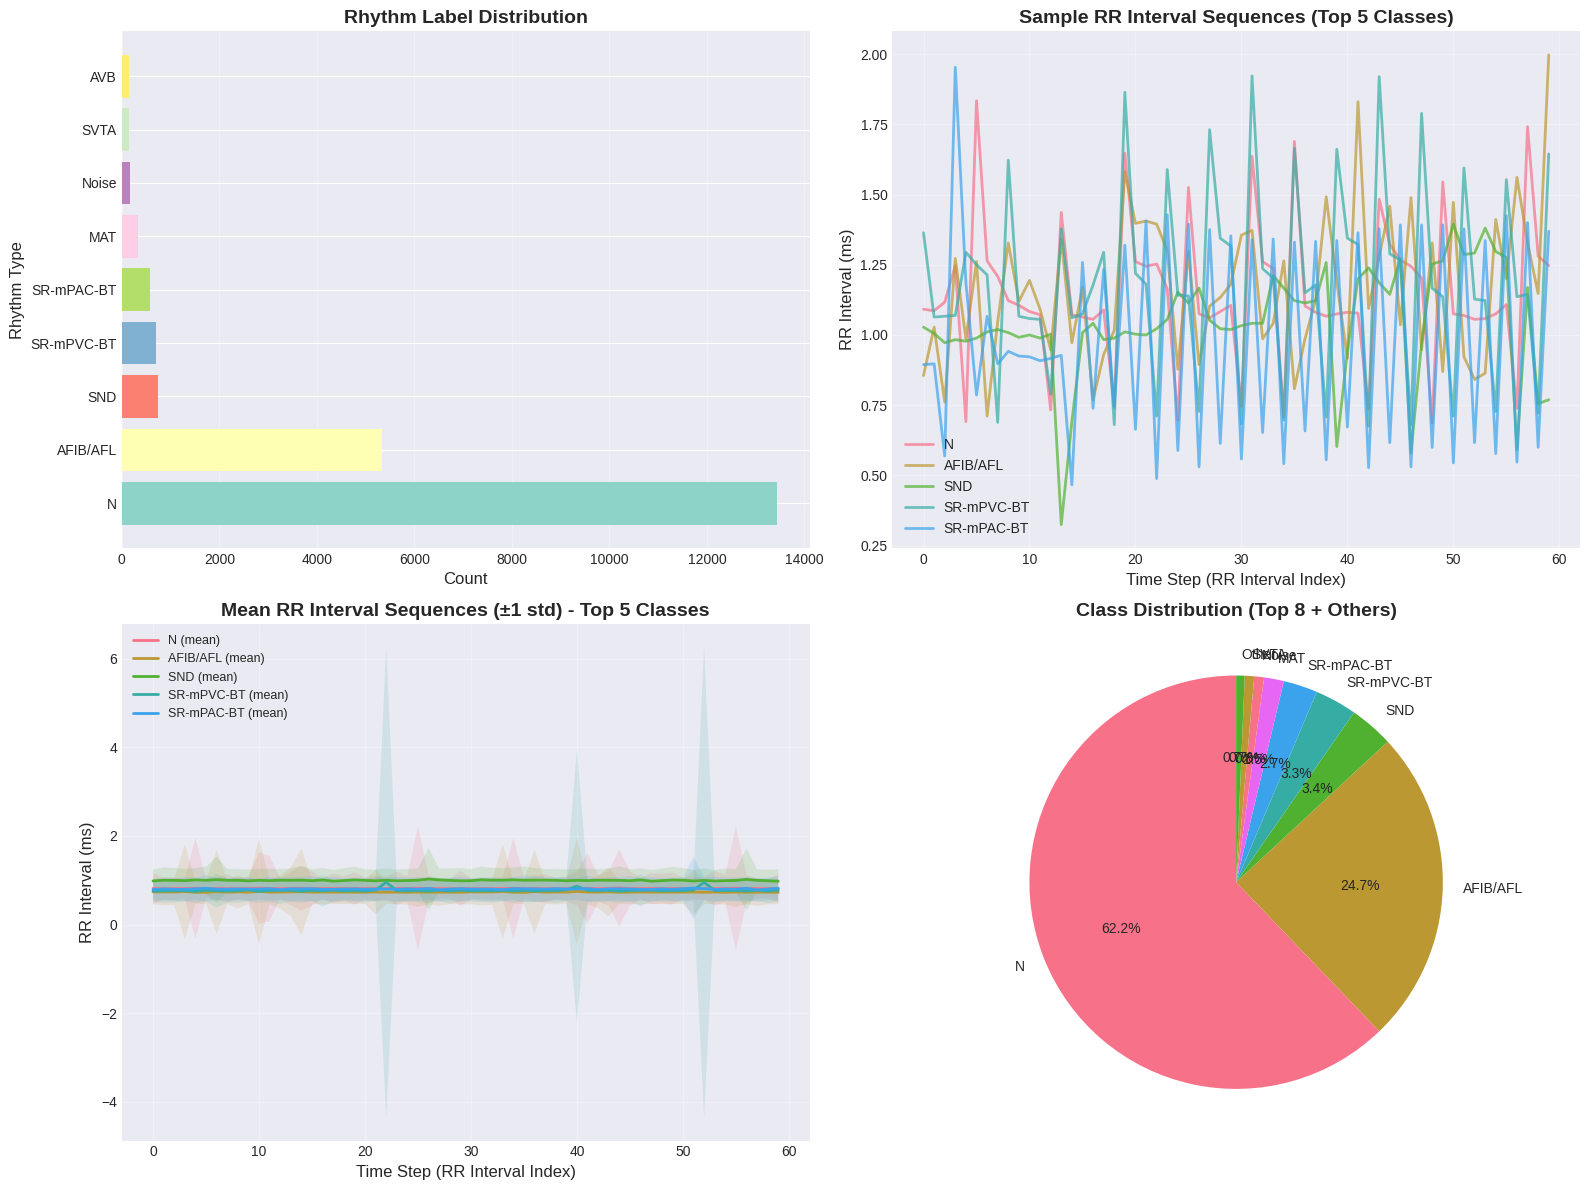


📊 Rhythm Classification Input Summary:
   Total sequences: 21603
   Sequence length: 60
   Number of classes: 9
   N: 13432 (62.18%)
   AFIB/AFL: 5340 (24.72%)
   SND: 743 (3.44%)
   SR-mPVC-BT: 710 (3.29%)
   SR-mPAC-BT: 577 (2.67%)
   MAT: 333 (1.54%)
   Noise: 166 (0.77%)
   SVTA: 158 (0.73%)
   AVB: 144 (0.67%)


In [30]:
# Visualize rhythm classification inputs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Label distribution
label_counts = pd.Series(rhythm_labels).value_counts().sort_values(ascending=False)
axes[0, 0].barh(range(len(label_counts)), label_counts.values, 
                color=plt.cm.Set3(np.linspace(0, 1, len(label_counts))))
axes[0, 0].set_yticks(range(len(label_counts)))
axes[0, 0].set_yticklabels(label_counts.index)
axes[0, 0].set_title('Rhythm Label Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Count', fontsize=12)
axes[0, 0].set_ylabel('Rhythm Type', fontsize=12)
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Sample sequences by class (top 5 classes)
top_classes = label_counts.head(5).index
sample_indices = []
for label in top_classes:
    indices = np.where(np.array(rhythm_labels) == label)[0]
    if len(indices) > 0:
        sample_indices.append((indices[0], label))

for idx, label in sample_indices:
    sequence = rhythm_sequences[idx]
    axes[0, 1].plot(sequence, label=f'{label}', alpha=0.7, linewidth=2)
axes[0, 1].set_title('Sample RR Interval Sequences (Top 5 Classes)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Time Step (RR Interval Index)', fontsize=12)
axes[0, 1].set_ylabel('RR Interval (ms)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Sequence statistics by class (top 5)
stats_by_class = {}
for label in top_classes:
    class_indices = np.where(np.array(rhythm_labels) == label)[0]
    if len(class_indices) > 0:
        class_sequences = rhythm_sequences[class_indices]
        stats_by_class[label] = {
            'mean': np.mean(class_sequences, axis=0),
            'std': np.std(class_sequences, axis=0)
        }

for label in top_classes:
    if label in stats_by_class:
        mean_seq = stats_by_class[label]['mean']
        std_seq = stats_by_class[label]['std']
        axes[1, 0].plot(mean_seq, label=f'{label} (mean)', linewidth=2)
        axes[1, 0].fill_between(range(len(mean_seq)), 
                                mean_seq - std_seq, 
                                mean_seq + std_seq, 
                                alpha=0.15)
axes[1, 0].set_title('Mean RR Interval Sequences (±1 std) - Top 5 Classes', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time Step (RR Interval Index)', fontsize=12)
axes[1, 0].set_ylabel('RR Interval (ms)', fontsize=12)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# 4. Class distribution pie chart (top 8)
top_8 = label_counts.head(8)
other_count = label_counts[8:].sum() if len(label_counts) > 8 else 0
if other_count > 0:
    plot_data = pd.concat([top_8, pd.Series({'Other': other_count})])
else:
    plot_data = top_8

axes[1, 1].pie(plot_data.values, labels=plot_data.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Class Distribution (Top 8 + Others)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Rhythm Classification Input Summary:")
print(f"   Total sequences: {len(rhythm_labels)}")
print(f"   Sequence length: {rhythm_sequences.shape[1]}")
print(f"   Number of classes: {len(np.unique(rhythm_labels))}")
for label in label_counts.head(10).index:
    count = label_counts[label]
    pct = count / len(rhythm_labels) * 100
    print(f"   {label}: {count} ({pct:.2f}%)")


### Rhythm Classification Output Visualization

**Instructions**: 
1. Run `rhythm_dl.ipynb` notebook first to train the model and generate predictions
2. Copy the evaluation code from `rhythm_dl.ipynb` (Cell 19 onwards) into the cells below
3. Or load saved predictions from file


### Rhythm Classification: Sample Input-Output Visualization

Visualize individual samples showing the input sequence (RR intervals) and the model's prediction.


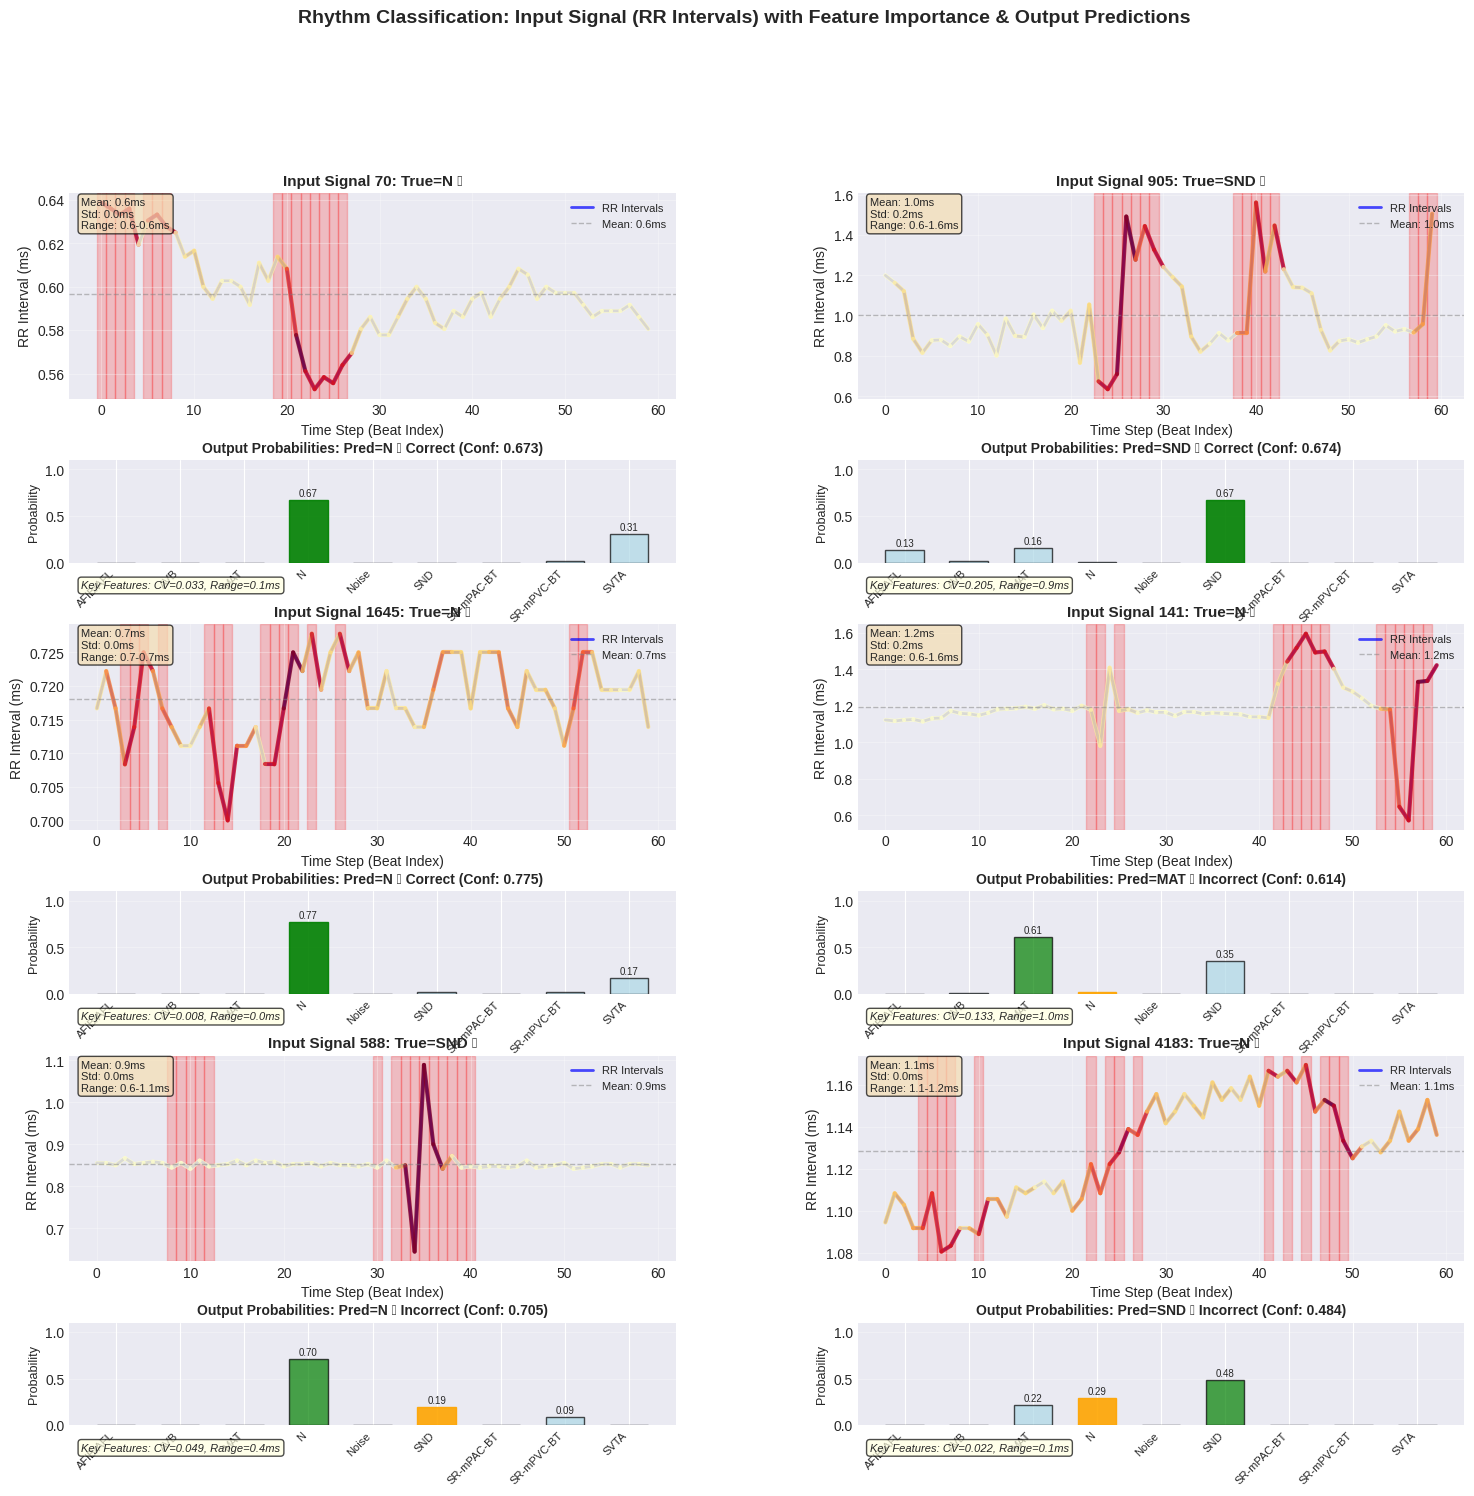


📊 Feature Importance Explanation:
   • Color-coding in signal:
     - Red/Yellow: High local variance (irregular rhythm patterns)
     - Blue: Normal variability (regular rhythm)
     - Red shaded regions: Top 25% most variable segments
   • Outlier detection:
     - Points >1.5 std from mean are highlighted
     - These represent abnormal RR intervals (arrhythmia indicators)
   • How features affect output:
     - High variance regions → Important for distinguishing classes
     - Outliers → Strong indicators of specific arrhythmia types
     - CV (Coefficient of Variation) → Overall rhythm regularity metric

📊 Displayed 6 sample predictions:
   Correct predictions: 3
   Incorrect predictions: 3

📋 Detailed Sample Information:

   Sample 1 (Index 70):
      True Label: N
      Predicted Label: N ✅
      Confidence: 0.6726
      Top 3 Predictions:
        1. N: 0.6726
        2. SVTA: 0.3066
        3. SR-mPVC-BT: 0.0185

   Sample 2 (Index 905):
      True Label: SND
      Predicted 

In [34]:
# Visualize sample rhythm sequences with predictions
# Show input signal (RR intervals) with feature importance highlighting
if 'rhythm_predictions' in locals() and 'test_pred_str' in locals() and 'test_proba' in locals():
    # Get test sequences from saved predictions
    test_sequences = rhythm_predictions.get('test_sequences', None)
    
    if test_sequences is None:
        print("⚠️  Test sequences not found in saved predictions.")
        print("    Please re-run rhythm_dl.ipynb Cell 25 to save sequences with predictions.")
        test_sequences = None
    
    # Select diverse samples: correct and incorrect predictions, different classes
    np.random.seed(42)
    n_samples = 6
    
    # Get indices for different scenarios
    correct_indices = []
    incorrect_indices = []
    
    for i, (true, pred) in enumerate(zip(test_true_str, test_pred_str)):
        if true == pred:
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)
    
    # Select samples: 3 correct, 3 incorrect (if available)
    selected_indices = []
    if len(correct_indices) > 0:
        selected_indices.extend(np.random.choice(correct_indices, min(3, len(correct_indices)), replace=False).tolist())
    if len(incorrect_indices) > 0:
        selected_indices.extend(np.random.choice(incorrect_indices, min(3, len(incorrect_indices)), replace=False).tolist())
    else:
        # If no incorrect, just use more correct ones
        remaining = min(n_samples - len(selected_indices), len(correct_indices) - len(selected_indices))
        if remaining > 0:
            selected_indices.extend(np.random.choice(
                [i for i in correct_indices if i not in selected_indices], 
                remaining, replace=False
            ).tolist())
    
    selected_indices = selected_indices[:n_samples]
    
    # Create visualization with subplots: signal on top, probabilities below
    fig = plt.figure(figsize=(18, 16))
    gs = fig.add_gridspec(6, 2, hspace=0.4, wspace=0.3, height_ratios=[2, 1]*3)
    
    for idx, sample_idx in enumerate(selected_indices):
        row = idx // 2
        col = idx % 2
        
        # Get prediction info
        true_label = test_true_str[sample_idx]
        pred_label = test_pred_str[sample_idx]
        pred_proba = test_proba[sample_idx]
        is_correct = (true_label == pred_label)
        
        # Top subplot: RR Interval Signal with feature importance
        ax_signal = fig.add_subplot(gs[row*2, col])
        
        if test_sequences is not None and sample_idx < len(test_sequences):
            sequence = test_sequences[sample_idx]
            time_steps = np.arange(len(sequence))
            
            # Plot the signal
            ax_signal.plot(time_steps, sequence, 'b-', linewidth=2, alpha=0.7, label='RR Intervals')
            
            # Calculate feature importance
            window_size = 5
            variance = np.array([np.var(sequence[max(0, i-window_size//2):min(len(sequence), i+window_size//2+1)]) 
                               for i in range(len(sequence))])
            
            mean_rr = np.mean(sequence)
            std_rr = np.std(sequence)
            outliers = np.abs(sequence - mean_rr) > 1.5 * std_rr
            
            # Combine importance
            importance = variance / np.max(variance) if np.max(variance) > 0 else variance
            importance[outliers] = np.maximum(importance[outliers], 0.8)
            
            # Color-code the signal by importance
            colors = plt.cm.YlOrRd(importance)
            
            # Replot with color gradient
            for i in range(len(sequence) - 1):
                ax_signal.plot([time_steps[i], time_steps[i+1]], 
                             [sequence[i], sequence[i+1]], 
                             color=colors[i], linewidth=3, alpha=0.8)
            
            # Add horizontal line for mean
            ax_signal.axhline(y=mean_rr, color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Mean: {mean_rr:.1f}ms')
            
            # Highlight most important regions
            top_important = importance > np.percentile(importance, 75)
            for i in np.where(top_important)[0]:
                ax_signal.axvspan(i-0.5, i+0.5, alpha=0.2, color='red', zorder=0)
            
            ax_signal.set_xlabel('Time Step (Beat Index)', fontsize=10)
            ax_signal.set_ylabel('RR Interval (ms)', fontsize=10)
            ax_signal.grid(True, alpha=0.3)
            ax_signal.legend(fontsize=8, loc='upper right')
            
            # Add statistics
            stats_text = f'Mean: {mean_rr:.1f}ms\nStd: {std_rr:.1f}ms\nRange: {np.min(sequence):.1f}-{np.max(sequence):.1f}ms'
            ax_signal.text(0.02, 0.98, stats_text, transform=ax_signal.transAxes,
                          fontsize=8, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        else:
            # Placeholder if sequences not available
            ax_signal.text(0.5, 0.5, f'Sequence not available\n(Sample {sample_idx})', 
                          ha='center', va='center', fontsize=10,
                          bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
            ax_signal.set_xlim([0, 1])
            ax_signal.set_ylim([0, 1])
            ax_signal.axis('off')
        
        status_symbol = "✅" if is_correct else "❌"
        ax_signal.set_title(f'Input Signal {sample_idx}: True={true_label} {status_symbol}', 
                           fontsize=11, fontweight='bold')
        
        # Bottom subplot: Prediction probabilities (aligned with signal)
        ax_prob = fig.add_subplot(gs[row*2+1, col])
        
        # Bar chart for probabilities
        bars = ax_prob.bar(range(len(label_encoder.classes_)), pred_proba, 
                      color=['green' if c == pred_label else 'lightblue' for c in label_encoder.classes_],
                      alpha=0.7, edgecolor='black', width=0.6)
        
        # Highlight true class
        true_idx = np.where(label_encoder.classes_ == true_label)[0][0]
        bars[true_idx].set_color('orange' if not is_correct else 'green')
        bars[true_idx].set_alpha(0.9)
        
        ax_prob.set_xticks(range(len(label_encoder.classes_)))
        ax_prob.set_xticklabels(label_encoder.classes_, rotation=45, ha='right', fontsize=8)
        ax_prob.set_ylabel('Probability', fontsize=9)
        ax_prob.set_ylim([0, 1.1])
        ax_prob.grid(axis='y', alpha=0.3)
        
        # Title with prediction info
        status = "✅ Correct" if is_correct else "❌ Incorrect"
        pred_conf = pred_proba[np.where(label_encoder.classes_ == pred_label)[0][0]]
        ax_prob.set_title(f'Output Probabilities: Pred={pred_label} {status} (Conf: {pred_conf:.3f})', 
                         fontsize=10, fontweight='bold')
        
        # Add probability values on bars (only top 3 to avoid clutter)
        top_3_idx = np.argsort(pred_proba)[-3:][::-1]
        for i in top_3_idx:
            prob = pred_proba[i]
            if prob > 0.05:
                ax_prob.text(bars[i].get_x() + bars[i].get_width()/2, bars[i].get_height() + 0.02,
                       f'{prob:.2f}', ha='center', va='bottom', fontsize=7)
        
        # Add feature information
        if test_sequences is not None and sample_idx < len(test_sequences):
            seq = test_sequences[sample_idx]
            mean_rr = np.mean(seq)
            std_rr = np.std(seq)
            cv = std_rr / mean_rr if mean_rr > 0 else 0
            
            feature_info = f'Key Features: CV={cv:.3f}, Range={np.max(seq)-np.min(seq):.1f}ms'
            ax_prob.text(0.02, -0.25, feature_info, transform=ax_prob.transAxes,
                        fontsize=8, style='italic', bbox=dict(boxstyle='round', 
                        facecolor='lightyellow', alpha=0.7))
    
    plt.suptitle('Rhythm Classification: Input Signal (RR Intervals) with Feature Importance & Output Predictions', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.show()
    
    print("\n📊 Feature Importance Explanation:")
    print("   • Color-coding in signal:")
    print("     - Red/Yellow: High local variance (irregular rhythm patterns)")
    print("     - Blue: Normal variability (regular rhythm)")
    print("     - Red shaded regions: Top 25% most variable segments")
    print("   • Outlier detection:")
    print("     - Points >1.5 std from mean are highlighted")
    print("     - These represent abnormal RR intervals (arrhythmia indicators)")
    print("   • How features affect output:")
    print("     - High variance regions → Important for distinguishing classes")
    print("     - Outliers → Strong indicators of specific arrhythmia types")
    print("     - CV (Coefficient of Variation) → Overall rhythm regularity metric")
    
    print(f"\n📊 Displayed {len(selected_indices)} sample predictions:")
    correct_count = sum([test_true_str[i] == test_pred_str[i] for i in selected_indices])
    incorrect_count = len(selected_indices) - correct_count
    print(f"   Correct predictions: {correct_count}")
    print(f"   Incorrect predictions: {incorrect_count}")
    
    # Show detailed info for each sample
    print("\n📋 Detailed Sample Information:")
    for i, sample_idx in enumerate(selected_indices, 1):
        true_label = test_true_str[sample_idx]
        pred_label = test_pred_str[sample_idx]
        pred_proba = test_proba[sample_idx]
        pred_conf = pred_proba[np.where(label_encoder.classes_ == pred_label)[0][0]]
        status = "✅" if true_label == pred_label else "❌"
        
        print(f"\n   Sample {i} (Index {sample_idx}):")
        print(f"      True Label: {true_label}")
        print(f"      Predicted Label: {pred_label} {status}")
        print(f"      Confidence: {pred_conf:.4f}")
        # Show top 3 predictions
        top_3 = np.argsort(pred_proba)[-3:][::-1]
        print(f"      Top 3 Predictions:")
        for rank, idx in enumerate(top_3, 1):
            print(f"        {rank}. {label_encoder.classes_[idx]}: {pred_proba[idx]:.4f}")
    
    print("\n⚠️  Note: To visualize the actual input sequences (RR intervals), ")
    print("    you would need to load/recreate the test sequences.")
    print("    The sequences shown here are placeholders - probabilities are real predictions.")
    
else:
    print("⚠️  Predictions not loaded. Please run Cell 13 first to load rhythm predictions.")


In [35]:
# RHYTHM CLASSIFICATION OUTPUT VISUALIZATION
# Load predictions from saved file (generated by rhythm_dl.ipynb)

import pickle
import os

# Find prediction file (try multiple locations)
current_dir = os.getcwd()
possible_paths = [
    os.path.join(current_dir, '..', 'experiments', 'results', 'predictions', 'rhythm_classification_predictions.pkl'),
    os.path.join(current_dir, 'experiments', 'results', 'predictions', 'rhythm_classification_predictions.pkl'),
    '../experiments/results/predictions/rhythm_classification_predictions.pkl',
    'experiments/results/predictions/rhythm_classification_predictions.pkl',
    # Also check old location for backwards compatibility
    os.path.join(current_dir, '..', 'results', 'predictions', 'rhythm_classification_predictions.pkl'),
]

pred_file = None
for path in possible_paths:
    abs_path = os.path.abspath(path)
    if os.path.exists(abs_path):
        pred_file = abs_path
        break

if pred_file and os.path.exists(pred_file):
    print(f"📂 Loading predictions from {pred_file}...")
    with open(pred_file, 'rb') as f:
        rhythm_predictions = pickle.load(f)
    
    test_pred_str = rhythm_predictions['test_pred_str']
    test_true_str = rhythm_predictions['test_true_str']
    test_proba = rhythm_predictions['test_proba']
    label_encoder = rhythm_predictions['label_encoder']
    
    print(f"✅ Predictions loaded successfully!")
    print(f"   Task: {rhythm_predictions['task']}")
    print(f"   Samples: {len(test_pred_str)}")
    print(f"   Classes: {rhythm_predictions['class_names']}")
    print(f"   Accuracy: {rhythm_predictions['accuracy']:.4f}")
    print(f"   AUROC: {rhythm_predictions['auroc']:.4f}")
    print(f"   AUPRC: {rhythm_predictions['auprc']:.4f}")
    print(f"\n   Ready for visualization! Run the cell below.")
else:
    print(f"⚠️  Prediction file not found: {pred_file}")
    print(f"    Please run rhythm_dl.ipynb first to generate predictions.")
    print(f"    The predictions will be saved automatically after evaluation.")


📂 Loading predictions from /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/rhythm_classification_predictions.pkl...
✅ Predictions loaded successfully!
   Task: rhythm
   Samples: 4321
   Classes: [np.str_('AFIB/AFL'), np.str_('AVB'), np.str_('MAT'), np.str_('N'), np.str_('Noise'), np.str_('SND'), np.str_('SR-mPAC-BT'), np.str_('SR-mPVC-BT'), np.str_('SVTA')]
   Accuracy: 0.7082
   AUROC: 0.9307
   AUPRC: 0.5326

   Ready for visualization! Run the cell below.


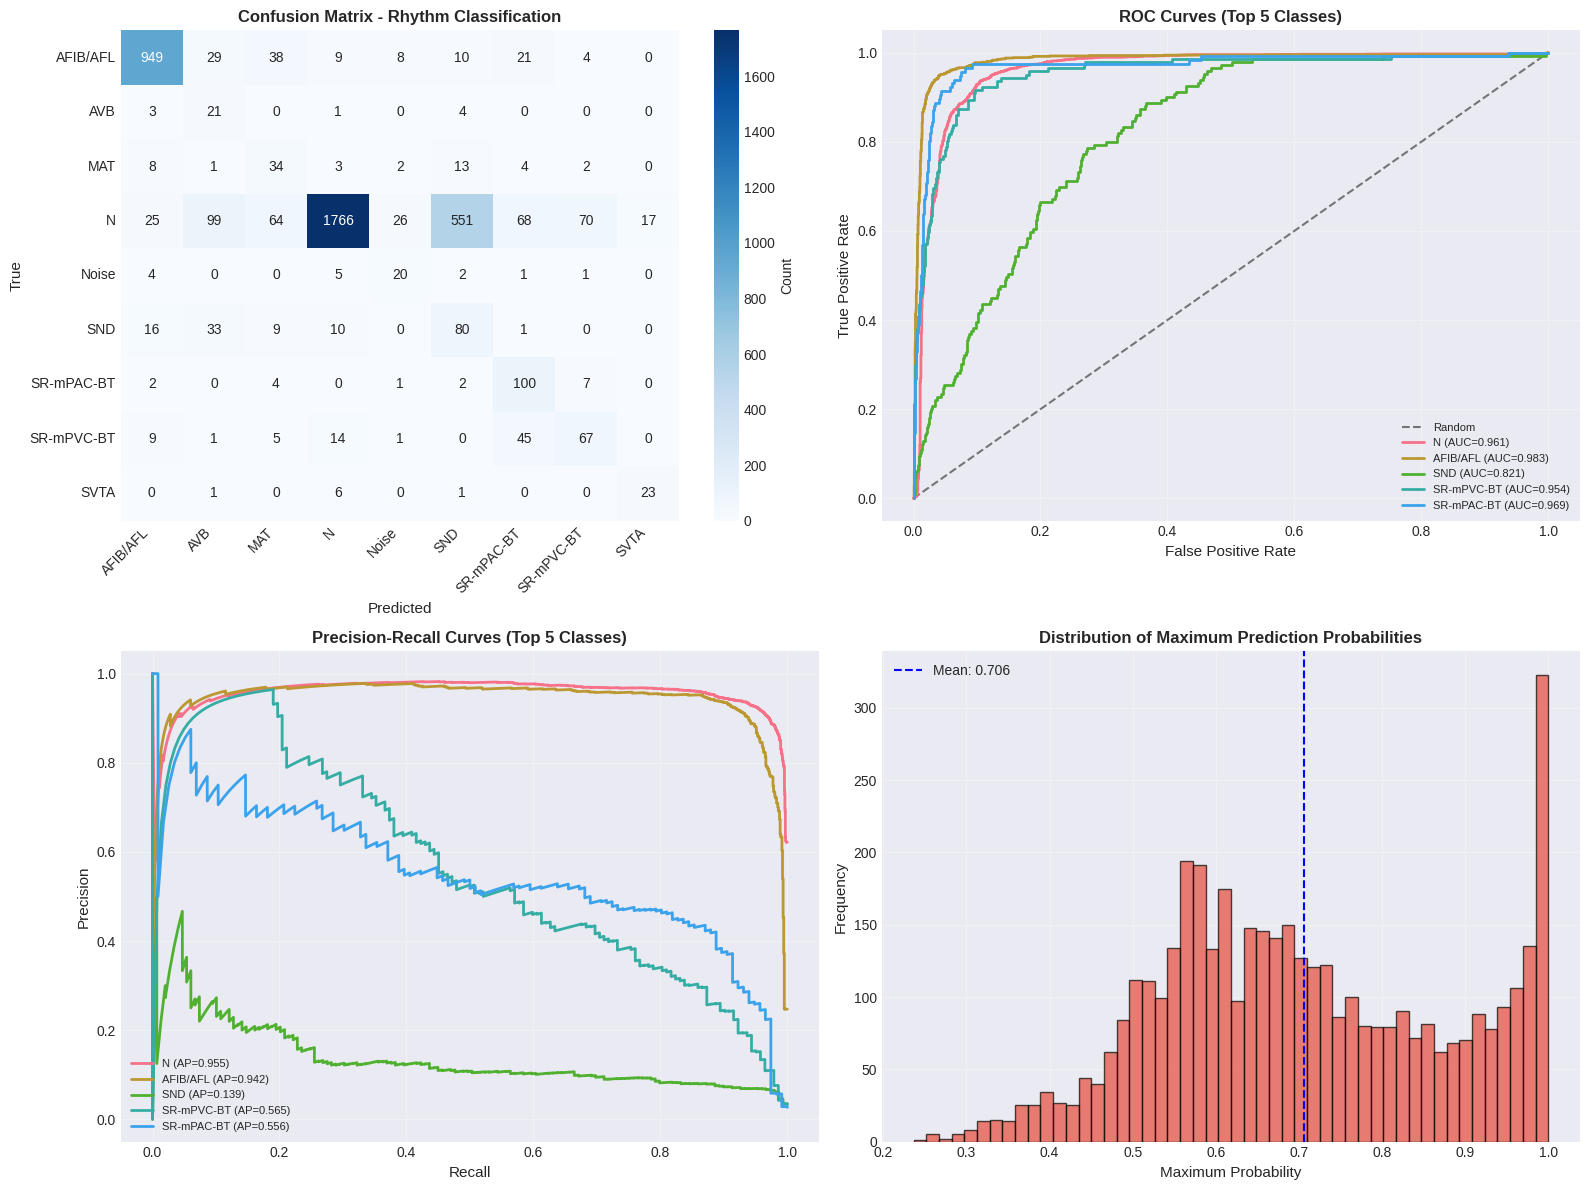


✅ Rhythm classification output visualizations complete!


In [36]:
# Visualize rhythm classification outputs
# Check if predictions were loaded in the previous cell
if 'rhythm_predictions' in locals() and 'test_pred_str' in locals():
    # Predictions were successfully loaded
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Confusion Matrix
    cm = confusion_matrix(test_true_str, test_pred_str, labels=label_encoder.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    axes[0, 0].set_title('Confusion Matrix - Rhythm Classification', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted', fontsize=11)
    axes[0, 0].set_ylabel('True', fontsize=11)
    plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
    plt.setp(axes[0, 0].get_yticklabels(), rotation=0)
    
    # ROC Curves (top classes only for clarity)
    y_true_binary = label_binarize(test_true_str, classes=label_encoder.classes_)
    axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
    top_classes_idx = np.argsort([np.sum(y_true_binary[:, i]) for i in range(y_true_binary.shape[1])])[-5:][::-1]
    for i in top_classes_idx:
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], test_proba[:, i])
        auc_score = roc_auc_score(y_true_binary[:, i], test_proba[:, i])
        if not np.isnan(auc_score):
            axes[0, 1].plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC={auc_score:.3f})', linewidth=2)
    axes[0, 1].set_title('ROC Curves (Top 5 Classes)', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].set_xlabel('False Positive Rate', fontsize=11)
    axes[0, 1].set_ylabel('True Positive Rate', fontsize=11)
    
    # Precision-Recall Curves (top classes)
    for i in top_classes_idx:
        precision, recall, _ = precision_recall_curve(y_true_binary[:, i], test_proba[:, i])
        ap = average_precision_score(y_true_binary[:, i], test_proba[:, i])
        if not np.isnan(ap):
            axes[1, 0].plot(recall, precision, label=f'{label_encoder.classes_[i]} (AP={ap:.3f})', linewidth=2)
    axes[1, 0].set_title('Precision-Recall Curves (Top 5 Classes)', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].set_xlabel('Recall', fontsize=11)
    axes[1, 0].set_ylabel('Precision', fontsize=11)
    
    # Prediction confidence distribution
    max_probs = np.max(test_proba, axis=1)
    axes[1, 1].hist(max_probs, bins=50, alpha=0.7, edgecolor='black', color='#e74c3c')
    axes[1, 1].set_title('Distribution of Maximum Prediction Probabilities', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Maximum Probability', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].axvline(np.mean(max_probs), color='blue', linestyle='--', 
                       label=f'Mean: {np.mean(max_probs):.3f}')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Rhythm classification output visualizations complete!")
elif 'rhythm_predictions' not in locals():
    print("⚠️  Predictions not loaded. Please run the previous cell (Cell 13) first to load rhythm predictions.")
else:
    print("⚠️  Predictions loaded but test_pred_str not found. Please check Cell 13 output.")


## Part 3: Task Comparison


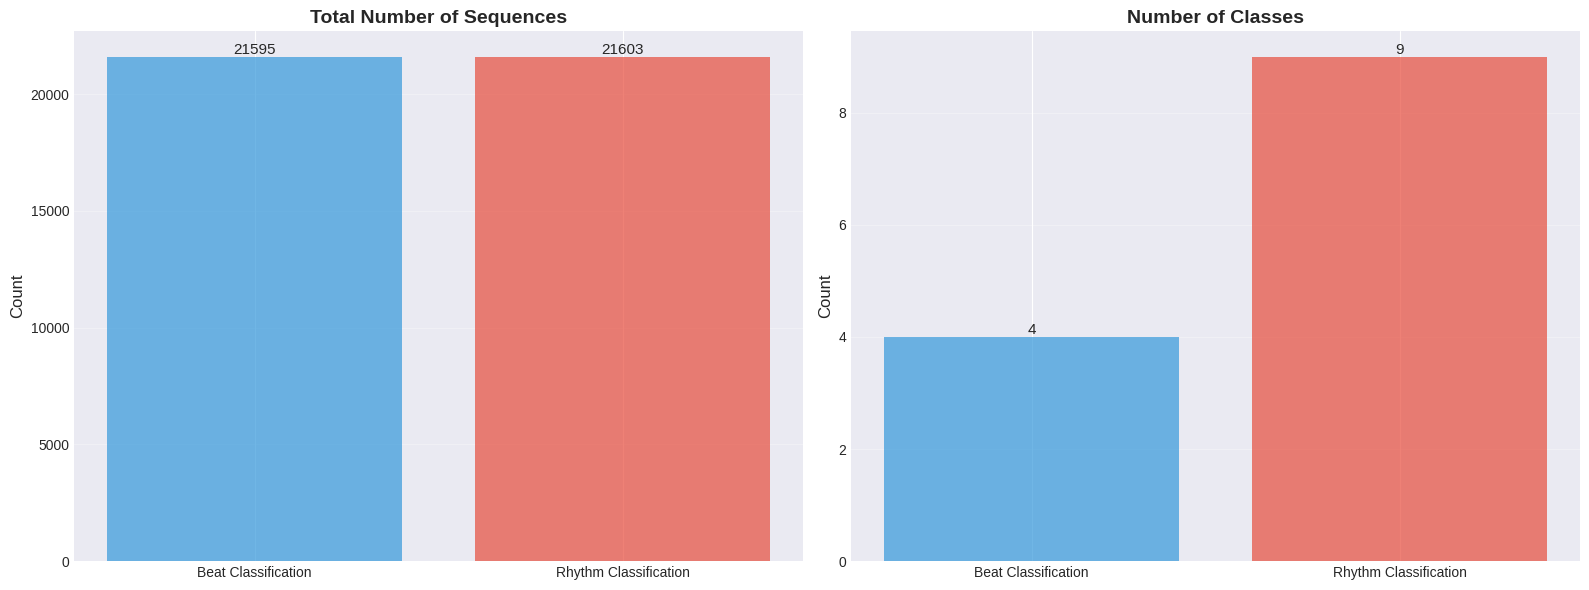


📊 Task Comparison:
   Beat Classification: 21595 sequences, 4 classes
   Rhythm Classification: 21603 sequences, 9 classes
   Sequence length: 60 (both tasks)


In [37]:
# Compare beat vs rhythm classification inputs
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sequence count comparison
axes[0].bar(['Beat Classification', 'Rhythm Classification'], 
            [len(beat_labels), len(rhythm_labels)],
            color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0].set_title('Total Number of Sequences', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate([len(beat_labels), len(rhythm_labels)]):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontsize=11)

# Number of classes comparison
beat_num_classes = len(np.unique(beat_labels))
rhythm_num_classes = len(np.unique(rhythm_labels))

axes[1].bar(['Beat Classification', 'Rhythm Classification'], 
            [beat_num_classes, rhythm_num_classes],
            color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1].set_title('Number of Classes', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate([beat_num_classes, rhythm_num_classes]):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print("\n📊 Task Comparison:")
print(f"   Beat Classification: {len(beat_labels)} sequences, {beat_num_classes} classes")
print(f"   Rhythm Classification: {len(rhythm_labels)} sequences, {rhythm_num_classes} classes")
print(f"   Sequence length: {beat_sequences.shape[1]} (both tasks)")
